In [643]:
## pip install --upgrade google-api-python-client

In [644]:
##  pip install --upgrade google-auth-oauthlib google-auth-httplib2

## pip install textblob


In [880]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import JSON

## Part 1 - YouTube API 

For the analysis, I decided to use data extracted using the YouTube Data API, available with Google Cloud.

With code available on the sources below, I extracted data on 10 YouTube Channels and more than 8000 of their publically availble videos. 

https://developers.google.com/youtube/v3/code_samples/code_snippets

https://www.youtube.com/watch?v=D56_Cx36oGY&t=528s&ab_channel=ThuVudataanalytics

The channels chosen all make videos related to personal finance. I selected them based on a Nasdaq article on the topic.

https://www.nasdaq.com/articles/10-best-youtube-channels-for-finance

The main variables I was interested in were the video titles, as well as important metrics such as view, like and comment count. In addition this, it was also important to know some basic information on the YouTube Channels selected so I was also interested in knowing their total subsciber count, as well as total number of videos uploaded. 



In [ ]:
api_key = "YOUR_API_KEY"

In [647]:
channel_ids = ['UCV6KDgJskWaEckne5aPA0aQ', #Graham Stephan
'UCGy7SkBjcIAgTiwkXEtPnYg', # Andrei Jikh
'UCO3tlaeZ6Z0ZN5frMZI3-uQ',  #Nate O'Brien
'UCL_v4tC26PvOFytV1_eEVSg', #WhiteBoard Finance
'UC3mjMoJuFnjYRBLon_6njbQ', #Ryan Scribner
'UCnMn36GT_H0X-w5_ckLtlgQ', #Financial Education
'UCSPYNpQ2fHv9HJ-q6MIMaPw', #The Financial Debt
'UCfRqvJFJ6LLQ62lKmOUXATw', #Nick True
'UCvs2mwDS-ZiIeJ01kvzarbQ', #Debt Free Millennials
'UCL8w_A8p8P1HWI3k6PR5Z6w', #Two Cents
            ]

In [648]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"

youtube = googleapiclient.discovery.build(
api_service_name, api_version, developerKey=api_key)

In [649]:
def get_channel_stats(youtube, channel_ids):

    all_data = []

    request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
    )
    response = request.execute()
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [650]:
channel_df = get_channel_stats(youtube, channel_ids)

In [651]:
def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [652]:
video_df = pd.DataFrame()

for c in channel_df['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_df.loc[channel_df['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    video_data = get_video_details(youtube, video_ids)

    video_df = pd.concat([video_df, video_data], ignore_index=True)

    

Getting video information from channel: Nate O'Brien
Getting video information from channel: Ryan Scribner
Getting video information from channel: Graham Stephan
Getting video information from channel: Andrei Jikh
Getting video information from channel: Debt Free Millennials
Getting video information from channel: Nick & Hanna True - MappedOutMoney
Getting video information from channel: Marko - WhiteBoard Finance
Getting video information from channel: Two Cents
Getting video information from channel: The Financial Diet
Getting video information from channel: Financial Education


# Part 2 - Data Preparation and Cleaning

To start preparing and cleaning our data, we can take a look at our dataframes and check the characteristics of the different columns, such as missing values, data type, etc.

In [653]:
channel_df

,channelName,subscribers,views,totalVideos,playlistId
0,Nate O'Brien,1300000,74252580,201,UUO3tlaeZ6Z0ZN5frMZI3-uQ
1,Ryan Scribner,833000,72990747,797,UU3mjMoJuFnjYRBLon_6njbQ
2,Graham Stephan,4890000,1056568529,1030,UUV6KDgJskWaEckne5aPA0aQ
3,Andrei Jikh,2460000,313676965,891,UUGy7SkBjcIAgTiwkXEtPnYg
4,Debt Free Millennials,104000,8987686,630,UUvs2mwDS-ZiIeJ01kvzarbQ
5,Nick & Hanna True - MappedOutMoney,63300,3945129,147,UUfRqvJFJ6LLQ62lKmOUXATw
6,Marko - WhiteBoard Finance,999000,64004411,320,UUL_v4tC26PvOFytV1_eEVSg
7,Two Cents,772000,60158888,204,UUL8w_A8p8P1HWI3k6PR5Z6w
8,The Financial Diet,1190000,149469394,1282,UUSPYNpQ2fHv9HJ-q6MIMaPw
9,Financial Education,766000,119630541,2653,UUnMn36GT_H0X-w5_ckLtlgQ


In [654]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,bwojg1i9dls,Nate O'Brien,Why I Disappeared (What Happened),Figured i'd update everyone. \nThanks for the ...,[nate o'brien],2024-05-21T21:51:47Z,255171,13071,None,1774,PT18M19S,hd,false
1,TM0NY4f0lGM,Nate O'Brien,Why It Costs More To Be Poor,"Buy, Sell, and Send Bitcoin on Cash App: https...","[nate o'brien, poor in america, how to get ric...",2023-09-18T19:01:48Z,99454,3530,None,422,PT12M29S,hd,false
2,bgGzNpEYv4I,Nate O'Brien,How I Stay Productive 99% of The Day,Less is more. Minimize rather than organize. \...,"[nate o'brien, how to be productive, productiv...",2023-08-14T18:53:01Z,199553,7537,None,290,PT9M30S,hd,false
3,C-Iewo7zUFo,Nate O'Brien,I Stopped Using My Phone. The results were sho...,I tried to not use my phone for 30 days. These...,"[nate o'brien, social media addiction, social ...",2023-07-27T19:35:12Z,519099,17269,None,1130,PT10M59S,hd,false
4,1qy1GX6gugw,Nate O'Brien,Venture Capital For Beginners (Complete Tutori...,Protect your money with up to $5M in FDIC insu...,"[nate o'brien, venture capital, venture capita...",2023-05-24T18:59:35Z,69295,2454,None,100,PT57M40S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8066,08c2eCDMjgo,Financial Education,What is a 401k,Link to join StockHub free investing discord s...,"[what is a 401k, 401k, what is a, 401k descrip...",2016-01-11T22:29:11Z,4384,169,None,8,PT1M43S,hd,false
8067,LZ68kdDv860,Financial Education,Difference between a Debit Card and Credit Card,Link to join StockHub free investing discord s...,[difference between a debit card and a credit ...,2016-01-07T07:15:18Z,17525,209,None,8,PT1M23S,hd,false
8068,OgDRHpWliko,Financial Education,What is a credit card,Link to join StockHub free investing discord s...,"[What is a credit card, Credit card, what is a...",2016-01-07T06:49:56Z,3375,115,None,13,PT1M37S,hd,false
8069,mhVdeIzxd7s,Financial Education,What is a savings account,Link to join StockHub free investing discord s...,"[what is a savings account, savings account, h...",2016-01-06T19:14:24Z,9882,228,None,21,PT1M14S,hd,false


In [655]:
print(channel_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  10 non-null     object
 1   subscribers  10 non-null     object
 2   views        10 non-null     object
 3   totalVideos  10 non-null     object
 4   playlistId   10 non-null     object
dtypes: object(5)
memory usage: 532.0+ bytes
None


In [656]:
print(video_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        8071 non-null   object
 1   channelTitle    8071 non-null   object
 2   title           8071 non-null   object
 3   description     8071 non-null   object
 4   tags            7570 non-null   object
 5   publishedAt     8071 non-null   object
 6   viewCount       8071 non-null   object
 7   likeCount       8069 non-null   object
 8   favouriteCount  0 non-null      object
 9   commentCount    8068 non-null   object
 10  duration        8071 non-null   object
 11  definition      8071 non-null   object
 12  caption         8071 non-null   object
dtypes: object(13)
memory usage: 819.8+ KB
None


All of the data in the dataframes is saved as objects. To perform our analysis, we should convert it to the correct data types.

In [657]:
channel_df['subscribers'] = channel_df['subscribers'].fillna(0).astype(int) 
channel_df['views'] = channel_df['views'].fillna(0).astype(int)
channel_df['totalVideos'] = channel_df['totalVideos'].fillna(0).astype(int)

channel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  10 non-null     object
 1   subscribers  10 non-null     int64 
 2   views        10 non-null     int64 
 3   totalVideos  10 non-null     int64 
 4   playlistId   10 non-null     object
dtypes: int64(3), object(2)
memory usage: 532.0+ bytes


Similarly, we need to convert the view, like and comment counts of videos to integers.

We can also convert the published date column to datetime format and video duration to timedelta format.

And since the "favouriteCount" column has no data, we can remove it.

In [658]:
video_df["viewCount"] = video_df["viewCount"].fillna(0).astype(int)
video_df["likeCount"] = video_df["likeCount"].fillna(0).astype(int)
video_df["commentCount"] = video_df["commentCount"].fillna(0).astype(int)

video_df["publishedAt"] = pd.to_datetime(video_df["publishedAt"])
video_df["duration"]= pd.to_timedelta(video_df["duration"].fillna(0))

video_df = video_df.drop(columns=["favouriteCount"]) 

video_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   video_id      8071 non-null   object             
 1   channelTitle  8071 non-null   object             
 2   title         8071 non-null   object             
 3   description   8071 non-null   object             
 4   tags          7570 non-null   object             
 5   publishedAt   8071 non-null   datetime64[ns, UTC]
 6   viewCount     8071 non-null   int64              
 7   likeCount     8071 non-null   int64              
 8   commentCount  8071 non-null   int64              
 9   duration      8071 non-null   timedelta64[ns]    
 10  definition    8071 non-null   object             
 11  caption       8071 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(7), timedelta64[ns](1)
memory usage: 756.8+ KB


Finally, just so we can take a better look at how data is being updated, we can sort the data frames: the channel data frame by the number of subscribers and the video data frame by the published date.

In [659]:
channel_df = channel_df.sort_values(by="subscribers", ascending=False).reset_index(drop=True)
video_df = video_df.sort_values(by="publishedAt", ascending=False).reset_index(drop=True)

YouTube Shorts are short-form video section in YouTube, created to make the website more competitive after the rise of TikTok and Instagram Reels and launched worldwide in July 2021 (Sternlicht, 2023)

Since videos are less than 3 minutes long and many are found when people are continuosly scrolling through the app rather than actively searching for the video, some of the metrics may behave differently. 

Because of this, a crucial step for our analysis is separating videos based on duration. 

Alexandra Sternlicht, August 2023, 
"YouTube’s Shorts already rivals TikTok with 2 billion views per month. Now it has ‘collabs,’ stickers for audience participation and other new features"
https://finance.yahoo.com/news/youtube-shorts-already-rivals-tiktok-160000612.html

In [660]:
short_videos = video_df[video_df["duration"] <= pd.Timedelta("3 minutes")].reset_index(drop=True)

short_videos = short_videos[short_videos["publishedAt"] > "2021-07-16"]

short_videos

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,Tq1tM5SUd8w,Two Cents,A Big Change to Home Prices You Haven’t Heard ...,,None,2024-11-22 02:44:56+00:00,113619,5404,276,0 days 00:01:00,hd,false
1,ZCdNHW6xjh0,Graham Stephan,HUGE Secret Restaurants Don’t Tell You!,Huge Secret Restaurants Don't Tell You! Featur...,None,2024-11-21 18:00:19+00:00,183757,4576,97,0 days 00:00:35,hd,false
2,XddJ76jsBgo,Debt Free Millennials,Balancing financial priorities and life transi...,Want to say YES to your next vacay without goi...,None,2024-11-20 19:15:54+00:00,875,0,0,0 days 00:00:19,hd,false
3,P0cEy4d4PHA,The Financial Diet,Reaction Mindfulness: Election Results,We have a responsibility to be aware of our pr...,None,2024-11-16 18:58:19+00:00,31786,2469,172,0 days 00:00:58,hd,false
4,ox6Ou5dWdxQ,The Financial Diet,A Word on Nuance: Election Results Reactions,,None,2024-11-13 23:10:44+00:00,59339,3016,214,0 days 00:00:53,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
910,HPs7c9QbupQ,Debt Free Millennials,4 Categories EVERY Budget Needs Regardless of ...,Want to say YES to your next vacay without goi...,None,2021-10-28 19:00:12+00:00,36434,572,3,0 days 00:00:12,hd,false
911,TNpaB9ubw6k,Debt Free Millennials,"Dear Marshall’s, take all my money",Want to say YES to your next vacay without goi...,None,2021-10-18 17:26:06+00:00,3089,76,1,0 days 00:00:08,hd,false
912,jJs_BXmmLMg,Financial Education,THEY CRASHED THE STOCK. UNREAL,7 Day free Trial for my Private Stock Group! L...,"[stocks to buy, stocks to watch]",2021-10-15 18:51:35+00:00,0,18,0,0 days 00:00:00,sd,false
913,T5erAkH7OVc,Debt Free Millennials,I Am The Sh!t,Want to say YES to your next vacay without goi...,None,2021-10-08 22:05:40+00:00,3097,65,3,0 days 00:00:11,hd,false


In [661]:
video_df = video_df[video_df["duration"] > pd.Timedelta("3 minutes")].reset_index(drop=True)

In [662]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,K9zjaINwFgA,The Financial Diet,Let's Talk About Entitlement Culture,"In this impromptu video, Chelsea responds to s...","[the financial diet, chelsea fagan, lauren ver...",2024-12-03 16:54:31+00:00,33770,1780,332,0 days 00:14:48,hd,false
1,k7N-EkAcvxU,Financial Education,5 Stocks I’m Buying Now‼️December 2024,✅ Looking to Join My Private Group & access 10...,"[stocks, stocks to buy, stocks to watch, stock...",2024-12-03 01:00:56+00:00,80159,6418,802,0 days 00:35:13,hd,false
2,g9h-W0x90FY,Graham Stephan,America is Financially Screwed (How To Save Yo...,Try Rocket Money for free: https://RocketMoney...,"[investing, investing for beginners, investing...",2024-12-02 22:00:23+00:00,283018,12025,1445,0 days 00:15:43,hd,false
3,DTBi6nl-n9E,Debt Free Millennials,More Home Improvement Projects! | September 20...,So glad you're here for another fun episode of...,"[debt free living, debt free millennials, just...",2024-11-29 18:00:14+00:00,2240,111,13,0 days 00:15:36,hd,false
4,fC-K5ESRx9E,Financial Education,I will BUY this Stock & SELL this Stock‼️,✅ Black Friday sale link for 1000xstocks\nhttp...,"[stocks to buy, stocks to watch, stocks, stock...",2024-11-29 01:40:19+00:00,92437,6776,1111,0 days 00:36:43,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...
7081,TEPfiDf_BYw,The Financial Diet,How To Quit Your Job | The Financial Diet,Chelsea & Lauren teach you how to responsibly ...,"[the financial diet, chelsea fagan, lauren ver...",2015-09-29 18:11:01+00:00,53434,1169,56,0 days 00:05:25,hd,false
7082,VXzLC82KNVA,The Financial Diet,How To Start Dreaming Medium | The Financial Diet,The Financial Diet blog:\nhttp://www.thefinanc...,"[the financial diet, chelsea fagan, lauren ver...",2015-09-22 22:48:25+00:00,48905,1720,37,0 days 00:04:42,hd,false
7083,51gzFoFAVTY,The Financial Diet,Having A Side Hustle | The Financial Diet,"Chelsea, and special guest Stephanie Georgopul...","[the financial diet, chelsea fagan, lauren ver...",2015-09-16 00:22:37+00:00,105989,2306,116,0 days 00:08:19,hd,false
7084,LxBzy10He5o,The Financial Diet,How To Save Money | The Financial Diet,Few things impact your life like learning how ...,"[the financial diet, chelsea fagan, lauren ver...",2015-09-08 21:39:14+00:00,146196,3266,93,0 days 00:04:21,hd,false


# Part 3 - Expolatory Data Analysis (EDA)

## 3.1 Summary Statistics

With all the data prepared, we can start to explore our data. 

The first think we can do is using the ".describe()" to get a summary of important metrics

In [663]:
channel_df.describe()

,subscribers,views,totalVideos
count,1.000000e+01,1.000000e+01,10.000000
mean,1.337730e+06,1.923685e+08,815.500000
std,1.416727e+06,3.162242e+08,754.574678
min,6.330000e+04,3.945129e+06,147.000000
25%,7.675000e+05,6.112027e+07,233.000000
50%,9.160000e+05,7.362166e+07,713.500000
75%,1.272500e+06,1.420097e+08,995.250000
max,4.890000e+06,1.056569e+09,2653.000000


Since the numbers are hard to read in the current format, we can make them more readable by making them integers, as well as adding commas to them.

In [664]:
channel_df_summary = channel_df.describe()

channel_df_summary[["views", "subscribers", "totalVideos"]] = channel_df_summary[["views", "subscribers", "totalVideos"]].astype(int)

# Making the numbers more readable
channel_df_summary["views"] = channel_df_summary["views"].apply(lambda x: "{:,}".format(x))
channel_df_summary["subscribers"] = channel_df_summary["subscribers"].apply(lambda x: "{:,}".format(x))

channel_df_summary

,subscribers,views,totalVideos
count,10,10,10
mean,"1,337,730","192,368,487",815
std,"1,416,726","316,224,183",754
min,"63,300","3,945,129",147
25%,"767,500","61,120,268",233
50%,"916,000","73,621,663",713
75%,"1,272,500","142,009,680",995
max,"4,890,000","1,056,568,529",2653


We can do the same thing for our videos dataframe

In [665]:
video_df = video_df[video_df["viewCount"] > 0]

video_df_summary = video_df.describe()

video_df_summary[["viewCount", "likeCount", "commentCount"]] = video_df_summary[["viewCount", "likeCount", "commentCount"]].astype(int)

video_df_summary["viewCount"] = video_df_summary["viewCount"].apply(lambda x: "{:,}".format(x))
video_df_summary["likeCount"] = video_df_summary["likeCount"].apply(lambda x: "{:,}".format(x))
video_df_summary["commentCount"] = video_df_summary["commentCount"].apply(lambda x: "{:,}".format(x))

video_df_summary

,viewCount,likeCount,commentCount,duration
count,"7,086","7,086","7,086",7086
mean,"174,071","7,652",689,0 days 00:16:59.758537962
std,"394,896","17,397","1,324",0 days 00:12:16.289850977
min,233,8,0,0 days 00:03:01
25%,"19,881",585,99,0 days 00:10:25
50%,"52,774","2,134",299,0 days 00:13:58
75%,"167,189","6,605",700,0 days 00:19:37
max,"8,648,250","310,610","29,558",0 days 04:00:17


Additionally, we can see how our totals look like, giving us a better understanding how big the niche we're analysing is. 

In [666]:
channel_df[["views", "subscribers", "totalVideos"]].sum().map("{:,}".format)

views          1,923,684,870
subscribers       13,377,300
totalVideos            8,155
dtype: object

In [667]:
video_df[["viewCount", "likeCount", "commentCount"]].sum().map("{:,}".format)

viewCount       1,233,469,818
likeCount          54,228,414
commentCount        4,888,105
dtype: object

## 3.2 Summary Statistics By Channel

We can also explore how these metrics look across channels. Let's analysing the sum, mean, median and max metrics for views, likes and comments.

In [668]:
video_df.groupby("channelTitle")[["viewCount"]].agg(["sum", "mean", "median", "max"]).round().sort_values(by=("viewCount", "sum"), ascending=False).style.format("{:,}")

In [669]:
video_df.groupby("channelTitle")[["likeCount"]].agg(["sum", "mean", "median", "max"]).round().sort_values(by=("likeCount", "sum"), ascending=False).style.format("{:,}")

In [670]:
video_df.groupby("channelTitle")[["commentCount"]].agg(["sum", "mean", "median", "max"]).round().sort_values(by=("commentCount", "sum"), ascending=False).style.format("{:,}")

## 3.3 TimeSeries

The finance niche, like any other YouTube topic, fluctuates according social trends. The interest people have in this type of content changes with time and, because of that, we should look at how the metrics we analysed have changed. For this, we will analyse monthly statistics for all of the channels. 

In [671]:
monthly_video_stats = video_df.groupby([pd.Grouper(key="publishedAt", freq="1M"), "channelTitle"])[["viewCount"]].agg(["count", "sum", "mean", "median", "max"]).round().reset_index()

monthly_video_stats.tail(10)

publishedAt                        channelTitle viewCount  \
                                                                      count   
822 2024-11-30 00:00:00+00:00                 Financial Education        11   
823 2024-11-30 00:00:00+00:00                      Graham Stephan         3   
824 2024-11-30 00:00:00+00:00          Marko - WhiteBoard Finance         5   
825 2024-11-30 00:00:00+00:00  Nick & Hanna True - MappedOutMoney         5   
826 2024-11-30 00:00:00+00:00                       Ryan Scribner         5   
827 2024-11-30 00:00:00+00:00                  The Financial Diet         4   
828 2024-11-30 00:00:00+00:00                           Two Cents         2   
829 2024-12-31 00:00:00+00:00                 Financial Education         1   
830 2024-12-31 00:00:00+00:00                      Graham Stephan         1   
831 2024-12-31 00:00:00+00:00                  The Financial Diet         1   

                                          
         sum      mean    median     max  
822  1334789  121344.0  112901.0  180837  
823  1380266  460089.0  420654.0  567653  
824    96032   19206.0   16469.0   25411  
825     8116    1623.0    1583.0    2639  
826   103720   20744.0    9681.0   49997  
827   584997  146249.0  136456.0  206781  
828    75344   37672.0   37672.0   37888  
829    80159   80159.0   80159.0   80159  
830   283018  283018.0  283018.0  283018  
831    33770   33770.0   33770.0   33770

Because of "viral" videos being common outliers that skew the averages in some months, we should make this time series analysis mainly looking at the median instead of the mean.

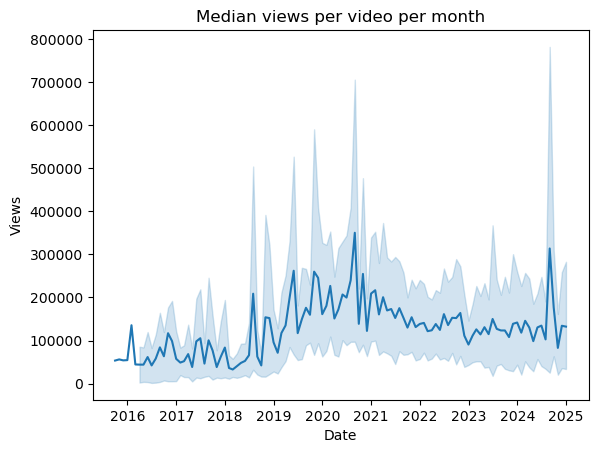

In [672]:
fig = plt.figure()

sns.lineplot(x=monthly_video_stats["publishedAt"], y=monthly_video_stats[("viewCount", "median")])

plt.title("Median views per video per month")
plt.ylabel("Views")
plt.xlabel("Date")

plt.show()

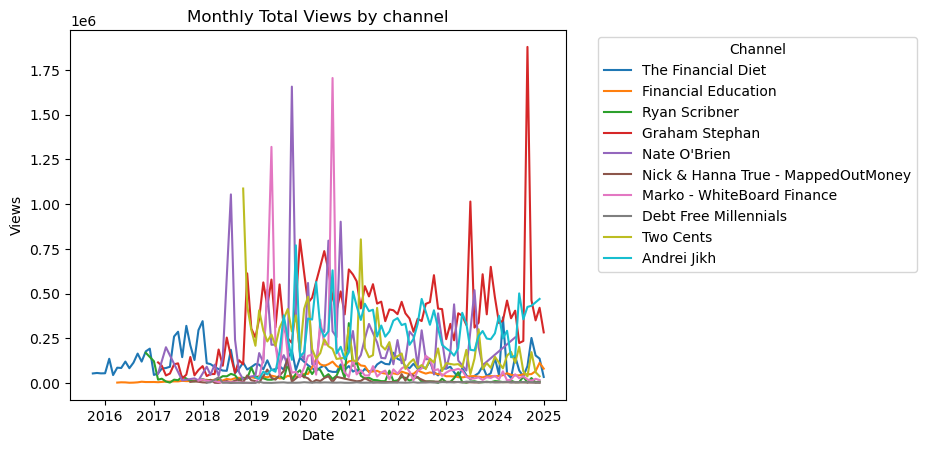

In [673]:

fig = plt.figure()
sns.lineplot(x=monthly_video_stats['publishedAt'], y=monthly_video_stats[("viewCount", "median")], hue=monthly_video_stats['channelTitle'])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Channel")


plt.title("Monthly Total Views by channel")
plt.ylabel("Views")
plt.xlabel("Date")

plt.show()

We can see that there was a general uptick in views during the pandemic but that part of that viewership was maintained afterwards. 

We also see how median viewership peaks at different times for channels, possibly because even within the finance space, people can do different types of content and that content is always changing. Some channels might decide to follow social trends and make a few videos talking about the stock market or real estate for example. 

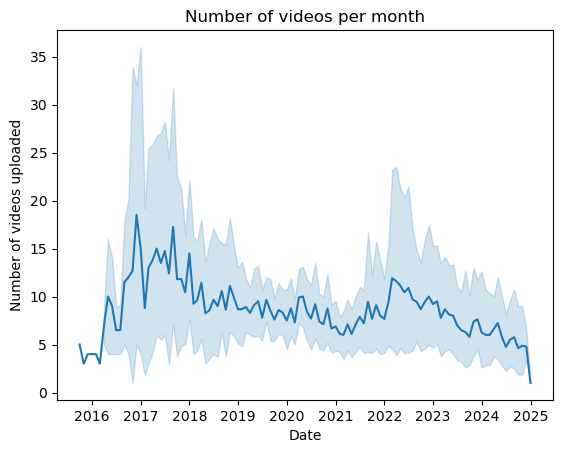

In [674]:
fig = plt.figure()

sns.lineplot(x=monthly_video_stats["publishedAt"], y=monthly_video_stats[("viewCount", "count")])

plt.title("Number of videos per month")
plt.ylabel("Number of videos uploaded")
plt.xlabel("Date")

plt.show()

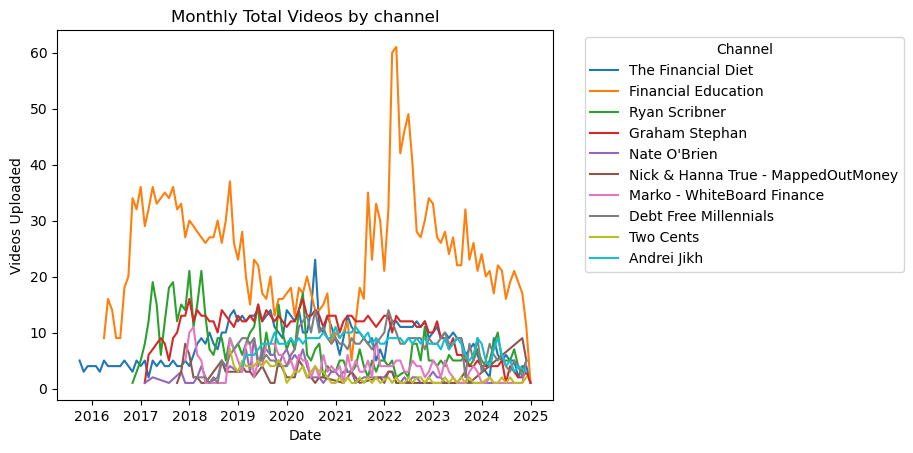

In [675]:
# Plot the lineplot with the filtered data
fig = plt.figure()
sns.lineplot(x=monthly_video_stats['publishedAt'], y=monthly_video_stats[("viewCount", "count")], hue=monthly_video_stats['channelTitle'])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Channel")
           
plt.title("Monthly Total Videos by channel")
plt.ylabel("Videos Uploaded")
plt.xlabel("Date")


plt.show()

<Axes: xlabel='publishedAt', ylabel="('viewCount', 'median')">

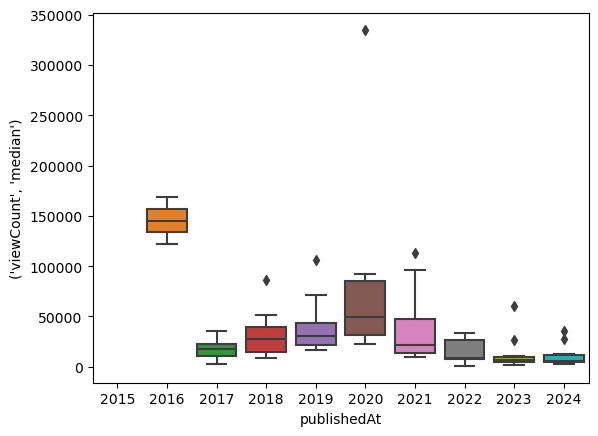

In [676]:
sns.boxplot(y=monthly_video_stats[monthly_video_stats["channelTitle"] == "Ryan Scribner"][("viewCount", "median")], x=monthly_video_stats["publishedAt"].dt.year)

Just looking at how distribution looks for one of the channels we have, we see that even though there are some extreme outliers in some of the years, most of the videos these youtube channels make are around the same viewcount, possibly indicating that most of their videos are watched by a strong fanbase and the outliers are those that go beyond that or go "viral".

## 3.4 Further Exploratory Analysis 

To finalise our EDA, we can look at the relationship between likes and views. Some videos might have a high viewership numbers because of a flashy title or misleading thumbnail. Because of that, an accurate measure of quality is a videos's like ratio (% of viewers that liked the video)

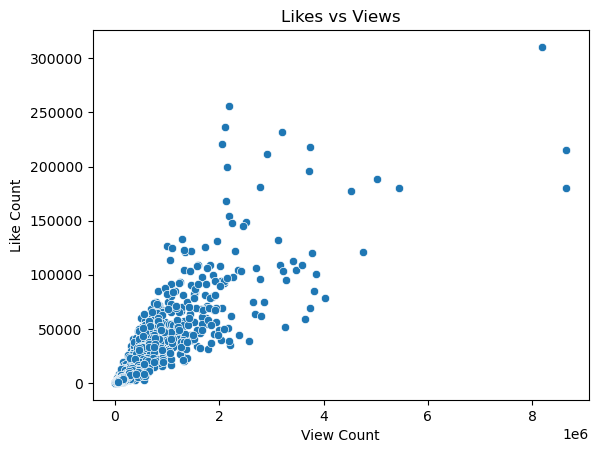

In [677]:
fig = plt.figure()
sns.scatterplot(x=video_df["viewCount"], y=video_df["likeCount"])

plt.title("Likes vs Views")
plt.ylabel("Like Count")
plt.xlabel("View Count")

plt.show()

In [678]:
video_df["likeRatio"] = video_df["likeCount"] / video_df["viewCount"]

In [679]:
video_df.groupby("channelTitle")[["likeRatio"]].agg(["mean", "median", "max"]).round(4).sort_values(by=("likeRatio", "mean"), ascending=False)

likeRatio                
                                        mean  median     max
channelTitle                                                
Graham Stephan                        0.0546  0.0524  0.1357
Andrei Jikh                           0.0466  0.0453  0.0835
Debt Free Millennials                 0.0450  0.0447  0.1040
Two Cents                             0.0426  0.0420  0.0665
Marko - WhiteBoard Finance            0.0422  0.0403  0.1055
Financial Education                   0.0403  0.0417  0.1139
Nick & Hanna True - MappedOutMoney    0.0397  0.0367  0.0980
Nate O'Brien                          0.0390  0.0389  0.0740
Ryan Scribner                         0.0372  0.0343  0.1420
The Financial Diet                    0.0329  0.0315  0.0824

In [680]:
like_counts = video_df.groupby("channelTitle")[["likeCount"]].sum().reset_index()

like_counts.rename(columns={'channelTitle': 'channelName'}, inplace=True)

channel_df = channel_df.merge(like_counts, on="channelName", how="left")

channel_df["likeRatio"] = (channel_df["likeCount"] / channel_df["views"]).round(4)

channel_df


,channelName,subscribers,views,totalVideos,playlistId,likeCount,likeRatio
0,Graham Stephan,4890000,1056568529,1030,UUV6KDgJskWaEckne5aPA0aQ,27338315,0.0259
1,Andrei Jikh,2460000,313676965,891,UUGy7SkBjcIAgTiwkXEtPnYg,8987232,0.0287
2,Nate O'Brien,1300000,74252580,201,UUO3tlaeZ6Z0ZN5frMZI3-uQ,2513318,0.0338
3,The Financial Diet,1190000,149469394,1282,UUSPYNpQ2fHv9HJ-q6MIMaPw,4050172,0.0271
4,Marko - WhiteBoard Finance,999000,64004411,320,UUL_v4tC26PvOFytV1_eEVSg,2098787,0.0328
5,Ryan Scribner,833000,72990747,797,UU3mjMoJuFnjYRBLon_6njbQ,1942584,0.0266
6,Two Cents,772000,60158888,204,UUL8w_A8p8P1HWI3k6PR5Z6w,2024635,0.0337
7,Financial Education,766000,119630541,2653,UUnMn36GT_H0X-w5_ckLtlgQ,4961995,0.0415
8,Debt Free Millennials,104000,8987686,630,UUvs2mwDS-ZiIeJ01kvzarbQ,206727,0.0230
9,Nick & Hanna True - MappedOutMoney,63300,3945129,147,UUfRqvJFJ6LLQ62lKmOUXATw,104649,0.0265


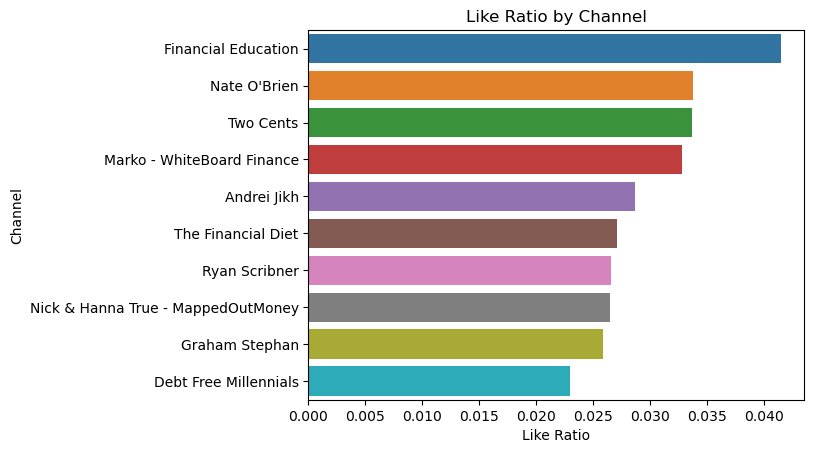

In [681]:
fig = plt.figure()
sns.barplot(x=channel_df["likeRatio"], y=channel_df.sort_values(by="likeRatio", ascending=False)["channelName"])

plt.title("Like Ratio by Channel")
plt.ylabel("Channel")
plt.xlabel("Like Ratio")

plt.show()

In the graph above, we see that Financial Education, despite not as popular as some other channels, has a really positive like ratio.

In [682]:
video_df["commentRatio"] = video_df["commentCount"] / video_df["viewCount"]

In [683]:
video_df.groupby("channelTitle")[["commentRatio"]].agg(["mean", "median", "max"]).round(4).sort_values(by=("commentRatio", "mean"), ascending=False).reset_index()

channelTitle commentRatio                
                                              mean  median     max
0                 Financial Education       0.0091  0.0080  0.0903
1               Debt Free Millennials       0.0088  0.0063  0.0441
2  Nick & Hanna True - MappedOutMoney       0.0076  0.0052  0.0728
3          Marko - WhiteBoard Finance       0.0070  0.0052  0.0415
4                      Graham Stephan       0.0058  0.0044  0.1159
5                         Andrei Jikh       0.0051  0.0043  0.0460
6                           Two Cents       0.0041  0.0031  0.0235
7                       Ryan Scribner       0.0040  0.0031  0.0556
8                        Nate O'Brien       0.0035  0.0028  0.0206
9                  The Financial Diet       0.0029  0.0024  0.0152

# Part 4 - Asking Questions About the Data

## 4.1 What is the impact of using popular keywords in the title of a video?

References used: 

https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas

### What are the most common words on video titles?

In [684]:
video_df["title"] 

0                    Let's Talk About Entitlement Culture
1                  5 Stocks I’m Buying Now‼️December 2024
2       America is Financially Screwed (How To Save Yo...
3       More Home Improvement Projects! | September 20...
4               I will BUY this Stock & SELL this Stock‼️
                              ...                        
7081            How To Quit Your Job | The Financial Diet
7082    How To Start Dreaming Medium | The Financial Diet
7083           Having A Side Hustle  | The Financial Diet
7084               How To Save Money | The Financial Diet
7085                        Welcome To The Financial Diet
Name: title, Length: 7086, dtype: object

In [685]:
from collections import Counter
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

video_df["titleWords"] = video_df['title'].apply(remove_punctuations)

common_words = Counter(" ".join(video_df["titleWords"]).lower().split()).most_common(200)

common_words

[('the', 1962),
 ('to', 1857),
 ('how', 1224),
 ('stock', 1222),
 ('in', 1007),
 ('a', 956),
 ('i', 913),
 ('market', 882),
 ('is', 787),
 ('stocks', 728),
 ('for', 650),
 ('my', 641),
 ('money', 618),
 ('you', 596),
 ('of', 488),
 ('why', 483),
 ('just', 474),
 ('this', 473),
 ('5', 423),
 ('now', 415),
 ('your', 390),
 ('on', 381),
 ('buy', 372),
 ('what', 357),
 ('financial', 355),
 ('and', 326),
 ('with', 326),
 ('tesla', 266),
 ('3', 261),
 ('investing', 253),
 ('make', 246),
 ('about', 238),
 ('do', 236),
 ('real', 233),
 ('best', 233),
 ('are', 231),
 ('it', 228),
 ('income', 216),
 ('buying', 211),
 ('7', 202),
 ('that', 199),
 ('will', 193),
 ('invest', 189),
 ('im', 189),
 ('2024', 188),
 ('diet', 188),
 ('beginners', 186),
 ('crash', 182),
 ('get', 182),
 ('10', 178),
 ('should', 178),
 ('budget', 170),
 ('things', 164),
 ('life', 162),
 ('6', 162),
 ('new', 156),
 ('estate', 155),
 ('all', 151),
 ('from', 151),
 ('by', 148),
 ('ways', 146),
 ('top', 145),
 ('bitcoin', 145),

In [686]:
# We can see that a lot of words don't mean much by themselves, just being determiners or connectors. 
# Because of this, we removed words that are less than 4 characters long.

common_words = pd.DataFrame(common_words, columns=["word", "count"])

common_words.head(30)

common_words = common_words[common_words["word"].apply(len) > 3].reset_index(drop=True)

common_words.head()

,word,count
0,stock,1222
1,market,882
2,stocks,728
3,money,618
4,just,474


I thing to note is the fact before the filtering short words out, "how" and "to" were towards the top. 
A lot of youtube created content is around guiding viewers so one can assume that start with "How To" would be quite popular. Because of this, we can try to find the most common two sequenced words or "bigrams".

Reference Used for this portion:
https://www.geeksforgeeks.org/generate-bigrams-with-nltk/#generating-bigrams-using-nltk

### What are the most common bigrams on video titles?

In [687]:
import nltk
from collections import Counter

nltk.download("punkt")

words = nltk.word_tokenize(' '.join(video_df["titleWords"]).lower())
bigrams = list(nltk.bigrams(words))

bigram_counts = Counter(bigrams)

common_bigrams = bigram_counts.most_common(100)

common_bigrams


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/valterbarros/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[(('how', 'to'), 739),
 (('stock', 'market'), 656),
 (('the', 'stock'), 260),
 (('the', 'financial'), 192),
 (('financial', 'diet'), 185),
 (('for', 'beginners'), 163),
 (('real', 'estate'), 155),
 (('to', 'invest'), 151),
 (('to', 'buy'), 142),
 (('how', 'i'), 134),
 (('to', 'make'), 133),
 (('market', 'is'), 117),
 (('how', 'much'), 116),
 (('tesla', 'stock'), 113),
 (('why', 'i'), 112),
 (('’', 's'), 106),
 (('passive', 'income'), 102),
 (('market', 'crash'), 102),
 (('stocks', 'to'), 101),
 (('in', 'the'), 95),
 (('do', 'this'), 95),
 (('elon', 'musk'), 94),
 (('ways', 'to'), 93),
 (('this', 'is'), 89),
 (('3', 'stocks'), 87),
 (('the', 'market'), 85),
 (('invest', 'in'), 83),
 (('need', 'to'), 83),
 (('im', 'buying'), 83),
 (('beers', 'budgeting'), 81),
 (('in', '2024'), 81),
 (('i', 'just'), 80),
 (('you', 'need'), 77),
 (('stocks', 'im'), 76),
 (('about', 'to'), 75),
 (('to', 'get'), 74),
 (('this', 'now'), 70),
 (('buying', 'now'), 69),
 (('top', '5'), 67),
 (('you', 'should'),

With this we have a better look at popular terms used in finance youtube videos. Seeing terms such as "How to", "Stock Market", "For beginners", "Tesla Stock" and "Passive Income" gives an idea of the type of content in the the finance space. Some wording choices are also popular. Titles with "Why I", "Im Buying", "How I" appear to be quite popular. There could many reasons for this. Videos like this could perform better or they can create a more trustful relationship with the viewer. 

In [688]:
# dataframe to store the bigrams
bigram_df = pd.DataFrame(common_bigrams, columns=["bigram", "count"])

bigram_df["bigram"] = bigram_df["bigram"].apply(lambda x: ' '.join(x))


bigram_df = bigram_df.drop([3, 4, 15, 43]).reset_index(drop=True)

bigram_df

,bigram,count
0,how to,739
1,stock market,656
2,the stock,260
3,for beginners,163
4,real estate,155
...,...,...
91,stocks are,39
92,what i,38
93,in a,38
94,you can,38


With this information on the most common words and terms used in titles, we can try to compare videos that use them compare to the ones that don't. 

To analyse this, we can look at some plots using boolean variables that check whether or not a title contains one of the top words or bigrams.


### Are video statistics different based on the use of keywords? 

#### Starting with Bigrams

In [689]:
# Adding a binary variable to indicate if the video title contains one of the top bigrams

video_df["common_bigram"] = video_df["titleWords"].apply(lambda x: any(word in x for word in bigram_df["bigram"]))

print("Number of videos with common bigrams: ", video_df[["title", "common_bigram"]][video_df["common_bigram"]== True].shape[0])

print("Number of videos without common bigrams: ", video_df[["title", "common_bigram"]][video_df["common_bigram"]== False].shape[0])


Number of videos with common bigrams:  359
Number of videos without common bigrams:  6727


In [690]:
video_df.groupby("common_bigram")[["viewCount", "likeCount", "commentCount"]].agg(["mean", "median", "max"]).round().astype(int)

viewCount                 likeCount                commentCount  \
                   mean median      max      mean median     max         mean   
common_bigram                                                                   
False            177694  53613  8648250      7810   2190  310610          699   
True             106189  39033  1758769      4716   1339  106143          522   

                             
              median    max  
common_bigram                
False            302  29558  
True             254   6288

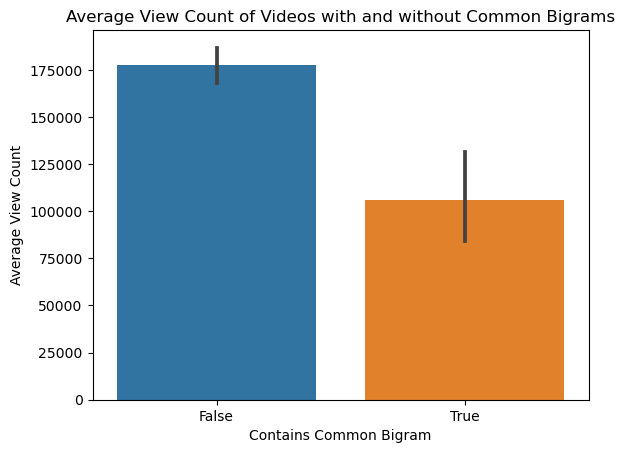

In [691]:
fig = plt.figure()
sns.barplot(x= video_df["common_bigram"], y= video_df["viewCount"])


plt.title("Average View Count of Videos with and without Common Bigrams")
plt.xlabel("Contains Common Bigram")
plt.ylabel("Average View Count")
plt.show()

We can also see if this is any different depending on the channel.

<Axes: xlabel='viewCount', ylabel='channelTitle'>

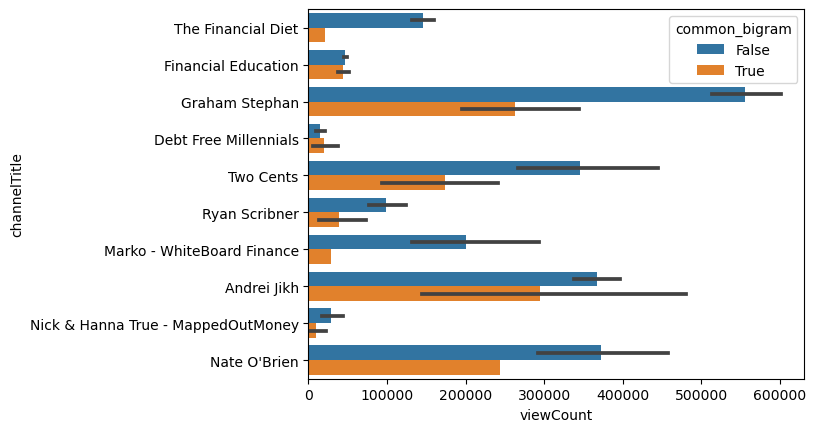

In [692]:
fig = plt.figure()
sns.barplot(x= video_df["viewCount"], y= video_df["channelTitle"], hue=video_df["common_bigram"])

In [693]:
quarterly_video_stats_with_bigrams = video_df.groupby([pd.Grouper(key="publishedAt", freq="Q"), "common_bigram"])[["viewCount"]].agg(["count", "sum", "mean", "median", "max"]).round().reset_index()

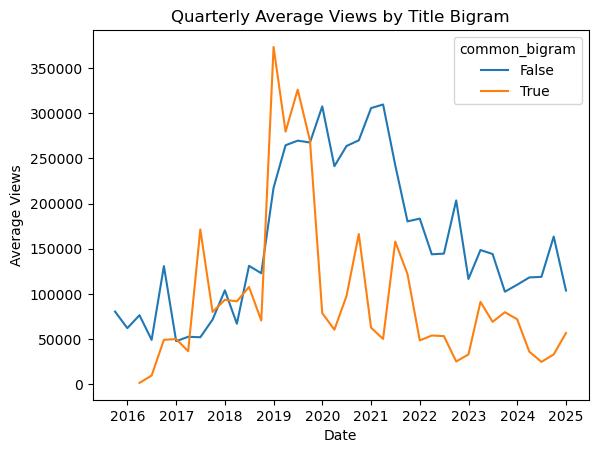

In [877]:
fig = plt.figure()

sns.lineplot(x=quarterly_video_stats_with_bigrams["publishedAt"], y=quarterly_video_stats_with_bigrams[("viewCount", "mean")], hue=quarterly_video_stats_with_bigrams["common_bigram"])

plt.title("Quarterly Average Views by Title Bigram")
plt.ylabel("Average Views")
plt.xlabel("Date")

plt.show()

#### Doing the same with Words

In [695]:
video_df["common_words"] = video_df["titleWords"].apply(lambda x: any(word in x for word in common_words["word"].head(75)))

print("Number of videos with common words: ",
    video_df[["title", "common_words"]][video_df["common_words"]== True].shape[0])

print("Number of videos without common word: ",
    video_df[["title", "common_words"]][video_df["common_words"]== False].shape[0])

Number of videos with common words:  1588
Number of videos without common word:  5498


In [696]:
video_df.groupby("common_words")[["viewCount", "likeCount", "commentCount"]].agg(["mean", "median", "max"]).round().astype(int)

viewCount                 likeCount                commentCount  \
                  mean median      max      mean median     max         mean   
common_words                                                                   
False           185685  56468  8648250      8233   2356  310610          734   
True            133863  37046  3638880      5646   1234  220669          535   

                            
             median    max  
common_words                
False           321  29558  
True            221   8615

In [697]:
video_df[["title", "common_words"]][video_df["common_words"]== True]

,title,common_words
1,5 Stocks I’m Buying Now‼️December 2024,True
3,More Home Improvement Projects! | September 20...,True
4,I will BUY this Stock & SELL this Stock‼️,True
9,How To Sell Options | Step By Step Tutorial (C...,True
20,5 Stocks to Buy within 30 Days‼️ Insane Gains ...,True
...,...,...
7044,Is Walmart next Kmart?,True
7049,Tesla take over of Auto Industry,True
7050,Stock market going to all time high?,True
7051,Who is next Steve Jobs,True


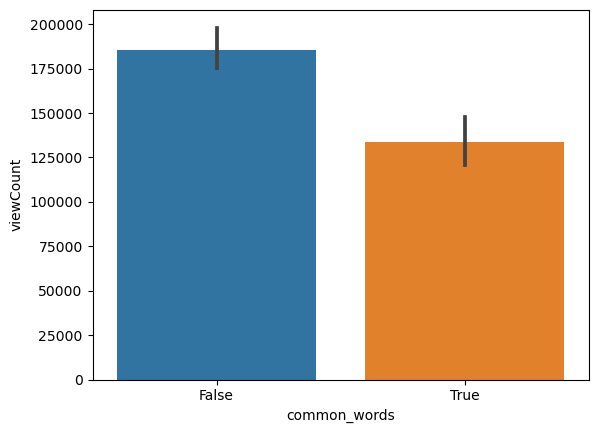

In [698]:
fig = plt.figure()
sns.barplot(x= video_df["common_words"], y= video_df["viewCount"])

plt.show()

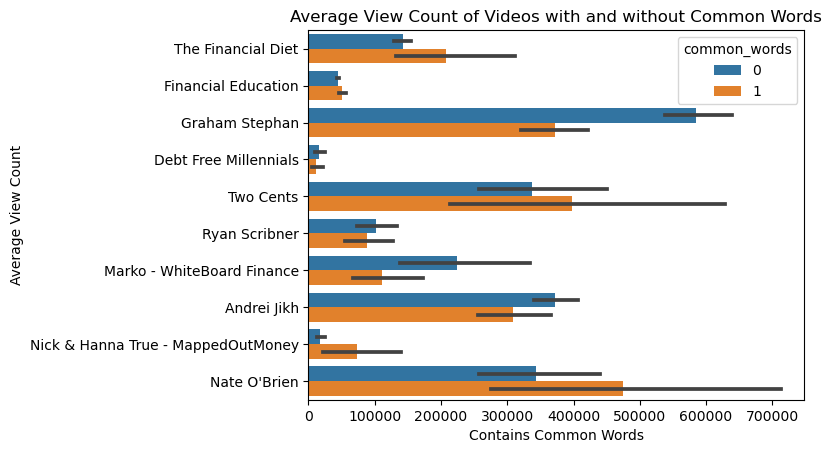

In [878]:
fig = plt.figure()
sns.barplot(x= video_df["viewCount"], y= video_df["channelTitle"], hue=video_df["common_words"])

plt.title("Average View Count of Videos with and without Common Words")
plt.xlabel("Contains Common Words")
plt.ylabel("Average View Count")

plt.show()

In [700]:
quarterly_video_stats_with_words = video_df.groupby([pd.Grouper(key="publishedAt", freq="Q"), "common_words"])[["viewCount"]].agg(["count", "sum", "mean", "median", "max"]).round().reset_index()

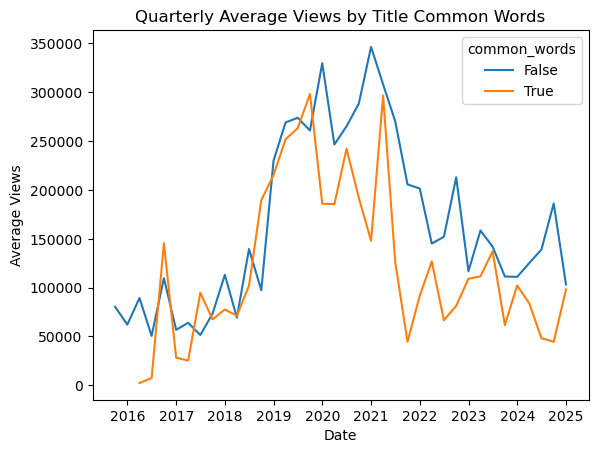

In [879]:
fig = plt.figure()

sns.lineplot(x=quarterly_video_stats_with_words["publishedAt"], y=quarterly_video_stats_with_words[("viewCount", "mean")], hue=quarterly_video_stats_with_words["common_words"])

plt.title("Quarterly Average Views by Title Common Words")
plt.ylabel("Average Views")
plt.xlabel("Date")

plt.show()

In both cases we see that the use of the most used keywords doesn't appear to have a significant of an impact on metrics like average view counts.

## 4.2 Does the Use of Extreme and Subjective Languague Increase Engagement?

Many believe that when the average YouTube user is looking for a video to watch, they're more likely to click on a flashy video with an over the top thumbnail. But one may wonder if that would be the case in the finance space. Is a video on how to invest safely boring? Would the same video perform better if it had a title talking about an imminent market crash or "THE BEST STOCKS TO INVEST IN"? To get to the bottom of this, we can use sentiment analysis. 

Simply put, it's a process of analysing text and measuring how positive it is, on a scale from -1 (negative sentiment) to 1 (positive sentiment)

For this, we used the "textblob" library and other online resources.

Reference Used: https://stackoverflow.com/questions/46764674/sentiment-analysis-on-dataframe

In [705]:
video_df[['polarity', 'subjectivity']] = video_df['title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [706]:
video_df[['channelTitle', 'title','viewCount', 'polarity', 'subjectivity']].sort_values(by="polarity", ascending=True)

,channelTitle,title,viewCount,polarity,subjectivity
5098,Financial Education,Facebook & Tesla Release Shocking Earnings,26809,-1.0,1.0
6255,Financial Education,Is Tai Lopez a Scam? **Shocking Truth**,69884,-1.0,1.0
6252,Financial Education,My Worst Investment Decision Ever,11641,-1.0,1.0
6249,Financial Education,OMG Pathetic Iphone 8 Demand!,8252,-1.0,1.0
5259,Graham Stephan,The 5 WORST Money Mistakes To Avoid In Your 20’s,659036,-1.0,1.0
...,...,...,...,...,...
2163,Ryan Scribner,3 Best Stock Market Investing Strategies For 2023,12714,1.0,0.3
4346,Graham Stephan,How To Get A PERFECT Credit Score For $0,2904954,1.0,1.0
4338,Ryan Scribner,M1 Finance vs Betterment | Best Robo Advisor?,13019,1.0,0.3
5102,The Financial Diet,"Unfiltered Thoughts On The PF Community, Best ...",69590,1.0,0.3


In [707]:
video_df[['channelTitle', 'title','viewCount', 'polarity', 'subjectivity']].sort_values(by="subjectivity", ascending=True)

,channelTitle,title,viewCount,polarity,subjectivity
0,The Financial Diet,Let's Talk About Entitlement Culture,33770,0.00,0.0
3954,The Financial Diet,Money Expert Farnoosh Torabi On Protecting You...,64655,0.00,0.0
3953,Nate O'Brien,How NOT To Invest In The Stock Market,72694,0.00,0.0
3950,Graham Stephan,Why I’m Not Leaving California | Responding To...,259309,0.00,0.0
3947,The Financial Diet,"On Anxiety, COVID 19, Financial Fear, & How TF...",85958,0.00,0.0
...,...,...,...,...,...
6109,Graham Stephan,Bitcoin Nears $17K: Why I FINALLY invested in ...,93282,0.00,1.0
1662,Financial Education,I Am Warning You. Be Very Careful,66037,-0.13,1.0
528,Graham Stephan,"URGENT: Federal Reserve ENDS Rate Hikes, Price...",564511,0.00,1.0
3994,Graham Stephan,An Important Message To All Investors,535559,0.40,1.0


Assuming both extremely negative and extremely positive videos attract viewers, we can use absolute value of polarity to measure how extreme they are.

In [708]:
video_df['polarity2'] = video_df['polarity'].abs()

In [709]:
video_df['common_words']=video_df['common_words'].astype(int)

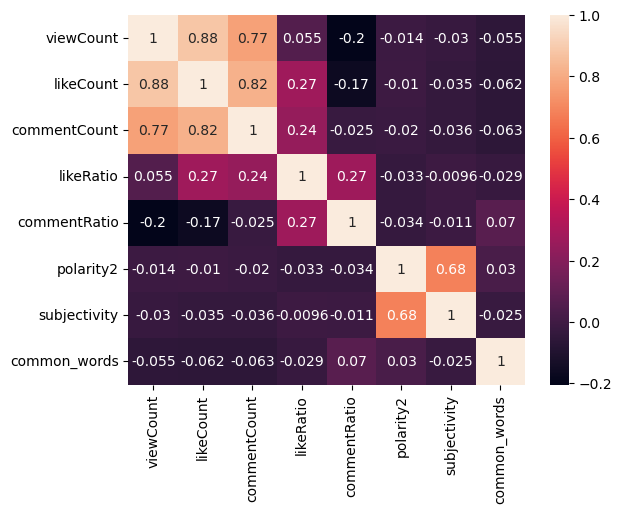

In [710]:
fig = plt.figure()

sns.heatmap(video_df[['viewCount', 'likeCount', 'commentCount', 'likeRatio', 'commentRatio', 'polarity2', 'subjectivity', 'common_words']].corr(), annot=True)

plt.show()

In [711]:
polarity_by_channel = video_df.groupby("channelTitle")[["polarity2", "subjectivity"]].mean().sort_values(by="polarity2", ascending=False).reset_index()

polarity_by_channel.rename(columns={'channelTitle': 'channelName'}, inplace=True)

channel_df_extra = channel_df.merge(polarity_by_channel, on="channelName", how="left")

In [712]:
channel_df_extra = channel_df.merge(polarity_by_channel, on="channelName", how="left")

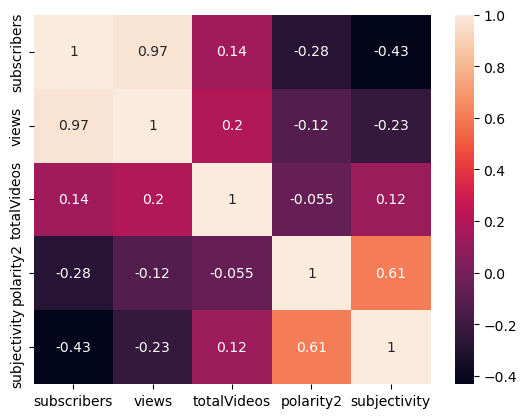

In [713]:
fig = plt.figure()

sns.heatmap(channel_df_extra[['subscribers', "views", 'totalVideos', 'polarity2', 'subjectivity']].corr(), annot=True)

plt.show()

We can see that the there is a negative correlation between the amount of subscribers a channel has and the average polarity and subjectivity of their video titles. This could be because bigger channels might not rely on using emotionally charged language, possibly to make their video more appealing to broader audiences.

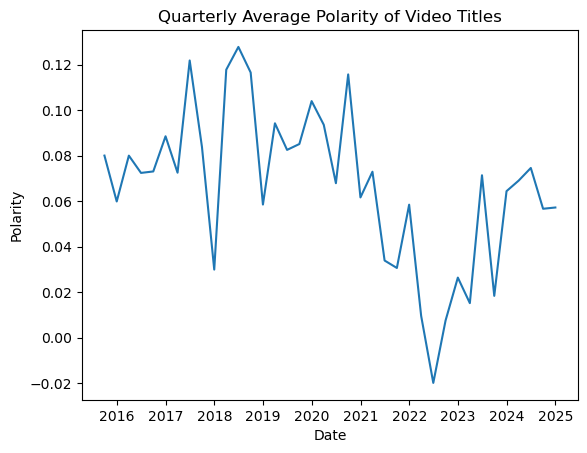

In [890]:
quarterly_video_stats_with_words = video_df.groupby(pd.Grouper(key="publishedAt", freq="Q"))[["viewCount", "polarity"]].agg({"viewCount": "mean", "polarity": "mean"}).reset_index()

fig = plt.figure()

sns.lineplot(x=quarterly_video_stats_with_words["publishedAt"], y=quarterly_video_stats_with_words["polarity"])

plt.title("Quarterly Average Polarity of Video Titles")
plt.ylabel("Polarity")
plt.xlabel("Date")

plt.show()

In this graph we see that average polarity in titls has been decreasing, which could be because of social trends. We see a big decline around Covid.

## 4.3 Does Short Form Content Behave Differently?

As we saw when preparing the data, a lot of the videos in the original dataset were short-form video content, mostly posted to "YouTube Shorts". Some of the videos with the highest view counts on the channels we analysed were YT shorts, meaning that just a small subsection of videos was skewing our data. But besides looking at view counts, we can go further and check in which ways short-form content behave differently to longer videos.

In [714]:
video_df.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,...,caption,likeRatio,commentRatio,titleWords,common_bigram,common_words,mentions stocks,polarity,subjectivity,polarity2
0,K9zjaINwFgA,The Financial Diet,Let's Talk About Entitlement Culture,"In this impromptu video, Chelsea responds to s...","[the financial diet, chelsea fagan, lauren ver...",2024-12-03 16:54:31+00:00,33770,1780,332,0 days 00:14:48,...,false,0.05271,0.009831,Lets Talk About Entitlement Culture,False,0,False,0.0,0.0,0.0


In [715]:
short_videos.describe()

,viewCount,likeCount,commentCount,duration
count,9.150000e+02,9.150000e+02,915.000000,915
mean,7.247429e+05,3.272562e+04,315.148634,0 days 00:00:46.057923497
std,3.636688e+06,1.744550e+05,1219.331340,0 days 00:00:19.262210315
min,0.000000e+00,0.000000e+00,0.000000,0 days 00:00:00
25%,1.068950e+04,3.585000e+02,9.000000,0 days 00:00:35
50%,2.346000e+04,1.009000e+03,32.000000,0 days 00:00:50
75%,7.037850e+04,3.276000e+03,117.500000,0 days 00:00:59
max,4.762659e+07,2.703436e+06,17135.000000,0 days 00:02:58


In [716]:
short_videos = short_videos[short_videos["viewCount"] > 0]

short_videos_summary = short_videos.describe()

short_videos_summary[["viewCount", "likeCount", "commentCount"]] = short_videos_summary[["viewCount", "likeCount", "commentCount"]].astype(int)

short_videos_summary["viewCount"] = short_videos_summary["viewCount"].apply(lambda x: "{:,}".format(x))
short_videos_summary["likeCount"] = short_videos_summary["likeCount"].apply(lambda x: "{:,}".format(x))
short_videos_summary["commentCount"] = short_videos_summary["commentCount"].apply(lambda x: "{:,}".format(x))

In [717]:
display("short videos", short_videos_summary)

display("long-form videos",video_df_summary)

'short videos'

,viewCount,likeCount,commentCount,duration
count,914,914,914,914
mean,"725,535","32,761",315,0 days 00:00:46.108315098
std,"3,638,599","174,547","1,219",0 days 00:00:19.212316832
min,517,0,0,0 days 00:00:05
25%,"10,704",362,9,0 days 00:00:35
50%,"23,665","1,010",32,0 days 00:00:50
75%,"71,049","3,279",117,0 days 00:00:59
max,"47,626,591","2,703,436","17,135",0 days 00:02:58


'long-form videos'

,viewCount,likeCount,commentCount,duration
count,"7,086","7,086","7,086",7086
mean,"174,071","7,652",689,0 days 00:16:59.758537962
std,"394,896","17,397","1,324",0 days 00:12:16.289850977
min,233,8,0,0 days 00:03:01
25%,"19,881",585,99,0 days 00:10:25
50%,"52,774","2,134",299,0 days 00:13:58
75%,"167,189","6,605",700,0 days 00:19:37
max,"8,648,250","310,610","29,558",0 days 04:00:17


In [881]:
# Giving the short videos dataframe all the treatment we gave to the long-form videos dataframe

short_videos["likeRatio"] = short_videos["likeCount"] / short_videos["viewCount"]

short_videos["commentRatio"] = short_videos["commentCount"] / short_videos["viewCount"]

short_videos["titleWords"] = short_videos['title'].apply(remove_punctuations)

short_videos["common_bigram"] = short_videos["titleWords"].apply(lambda x: any(word in x for word in bigram_df["bigram"]))

short_videos["common_words"] = short_videos["titleWords"].apply(lambda x: any(word in x for word in common_words["word"].head(75)))

short_videos["mentions stocks"] = short_videos["titleWords"].str.contains("stock|stocks|stock market|investing|investment", case=False)

short_videos[['polarity', 'subjectivity']] = short_videos['title'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

short_videos['polarity2'] = short_videos['polarity'].abs()

short_videos['common_words']=short_videos['common_words'].astype(int)

short_videos.head(1)   

/var/folders/bj/9jn0z_990vg0ghj4rs__0f7w0000gn/T/ipykernel_25780/3202239984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_videos["likeRatio"] = short_videos["likeCount"] / short_videos["viewCount"]
/var/folders/bj/9jn0z_990vg0ghj4rs__0f7w0000gn/T/ipykernel_25780/3202239984.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_videos["commentRatio"] = short_videos["commentCount"] / short_videos["viewCount"]
/var/folders/bj/9jn0z_990vg0ghj4rs__0f7w0000gn/T/ipykernel_25780/3202239984.py:7: Sett

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,...,caption,likeRatio,commentRatio,titleWords,common_bigram,common_words,mentions stocks,polarity,subjectivity,polarity2
0,Tq1tM5SUd8w,Two Cents,A Big Change to Home Prices You Haven’t Heard ...,,None,2024-11-22 02:44:56+00:00,113619,5404,276,0 days 00:01:00,...,false,0.047562,0.002429,A Big Change to Home Prices You Haven’t Heard ...,False,1,False,0.0,0.1,0.0


With this, we can create a larger dataframe with all videos, as well as variable that shows if a video is short form or long form.

In [751]:

all_videos = pd.concat([video_df[video_df["publishedAt"] > "2021-07-16"], short_videos], ignore_index=True)

all_videos["video_type"] = all_videos["duration"] <= pd.Timedelta("3 minutes")

all_videos["video_type"] = all_videos["video_type"].map({True: "short-form", False: "long-form"})

In [882]:
all_videos.head(1)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,...,video_type,ShortForm,polarity_ShortForm,subjectivity_ShortForm,subscribers,subscribers_shortform,viewCount_log,subscribers_log,subscribers_log_shortform,shortForm
0,K9zjaINwFgA,The Financial Diet,Let's Talk About Entitlement Culture,"In this impromptu video, Chelsea responds to s...","[the financial diet, chelsea fagan, lauren ver...",2024-12-03 16:54:31+00:00,33770,1780,332,0 days 00:14:48,...,long-form,0,0.0,0.0,1190000,0,10.427328,13.989464,0.0,0


In [796]:
monthly_video_stats_all = all_videos.groupby([pd.Grouper(key="publishedAt", freq="1M"), "video_type"])[["viewCount", "likeCount", "commentCount"]].agg(["count", "sum", "mean", "median", "var" ]).round().reset_index()

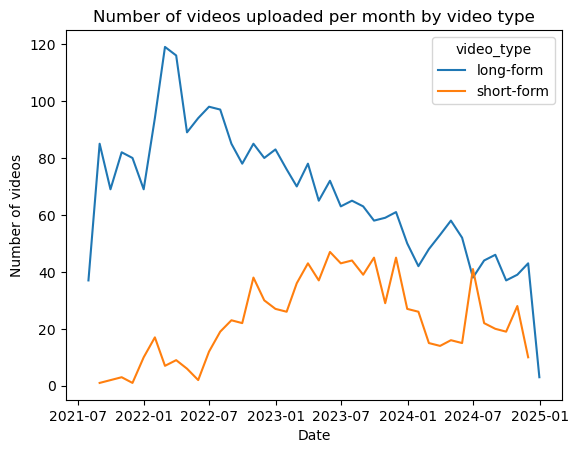

In [797]:
fig = plt.figure()

sns.lineplot(x=monthly_video_stats_all["publishedAt"], y=monthly_video_stats_all[("viewCount", "count")], hue=monthly_video_stats_all["video_type"])

plt.title("Number of videos uploaded per month by video type")
plt.ylabel("Number of videos")
plt.xlabel("Date")

plt.show()

With the graph above we see that, since the release of YT Shorts, the number of short-form videos has been gradually increasing, while the number of long form videos uploaded every month has been on a downward trend. 

<Axes: xlabel='video_type', ylabel='subjectivity'>

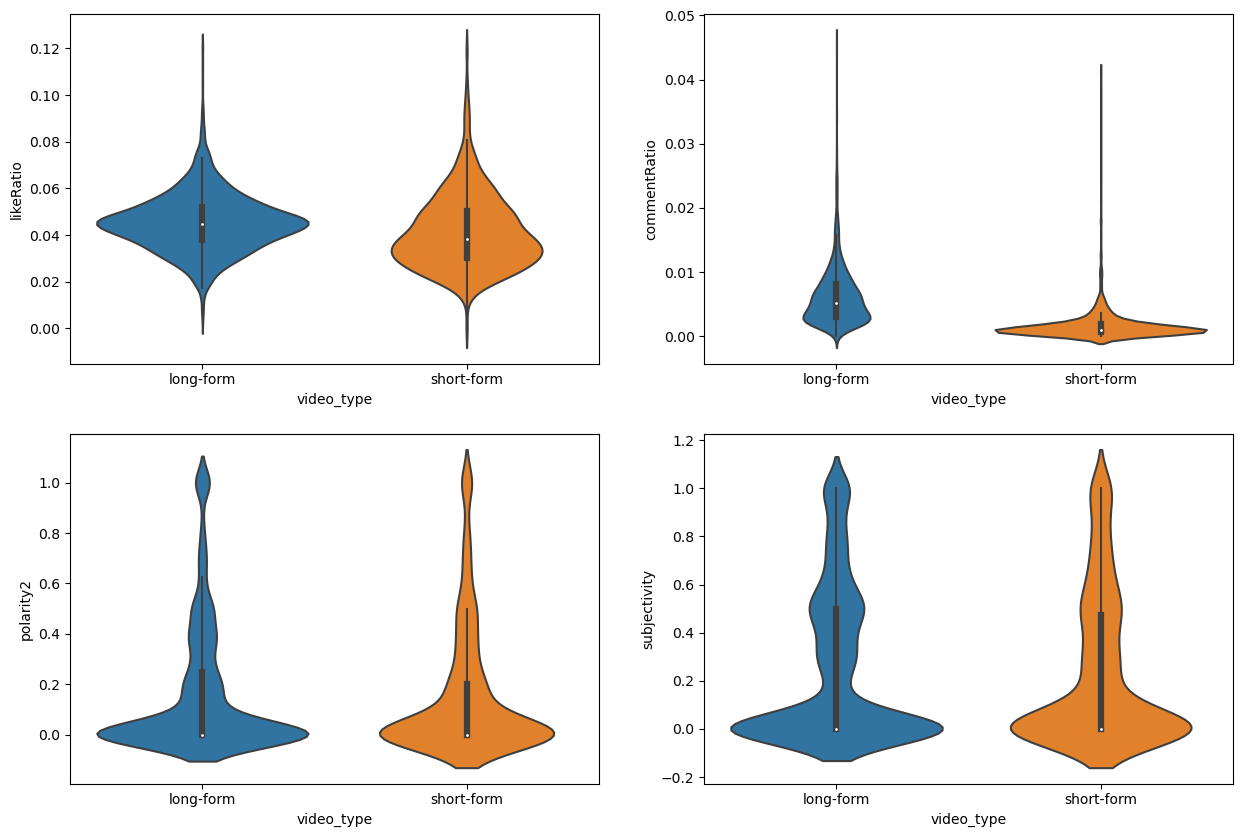

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.violinplot(x=all_videos["video_type"], y=all_videos["likeRatio"], ax=axs[0, 0])

sns.violinplot(x=all_videos["video_type"], y=all_videos["commentRatio"], ax=axs[0, 1])

sns.violinplot(x=all_videos["video_type"], y=all_videos["polarity2"], ax=axs[1, 0])

sns.violinplot(x=all_videos["video_type"], y=all_videos["subjectivity"], ax=axs[1, 1])

With the violin plots, we see that short form content tends to have a lower comment ratio but a higher like ratio. This can be because when people are simply scrolling through YT shorts, they won't stop to comment.

In [ ]:
# some months with few short form videos were skewing the data, so we should filter them out
monthly_video_stats_all_filtered = monthly_video_stats_all[monthly_video_stats_all[("viewCount", "count")] > 3]

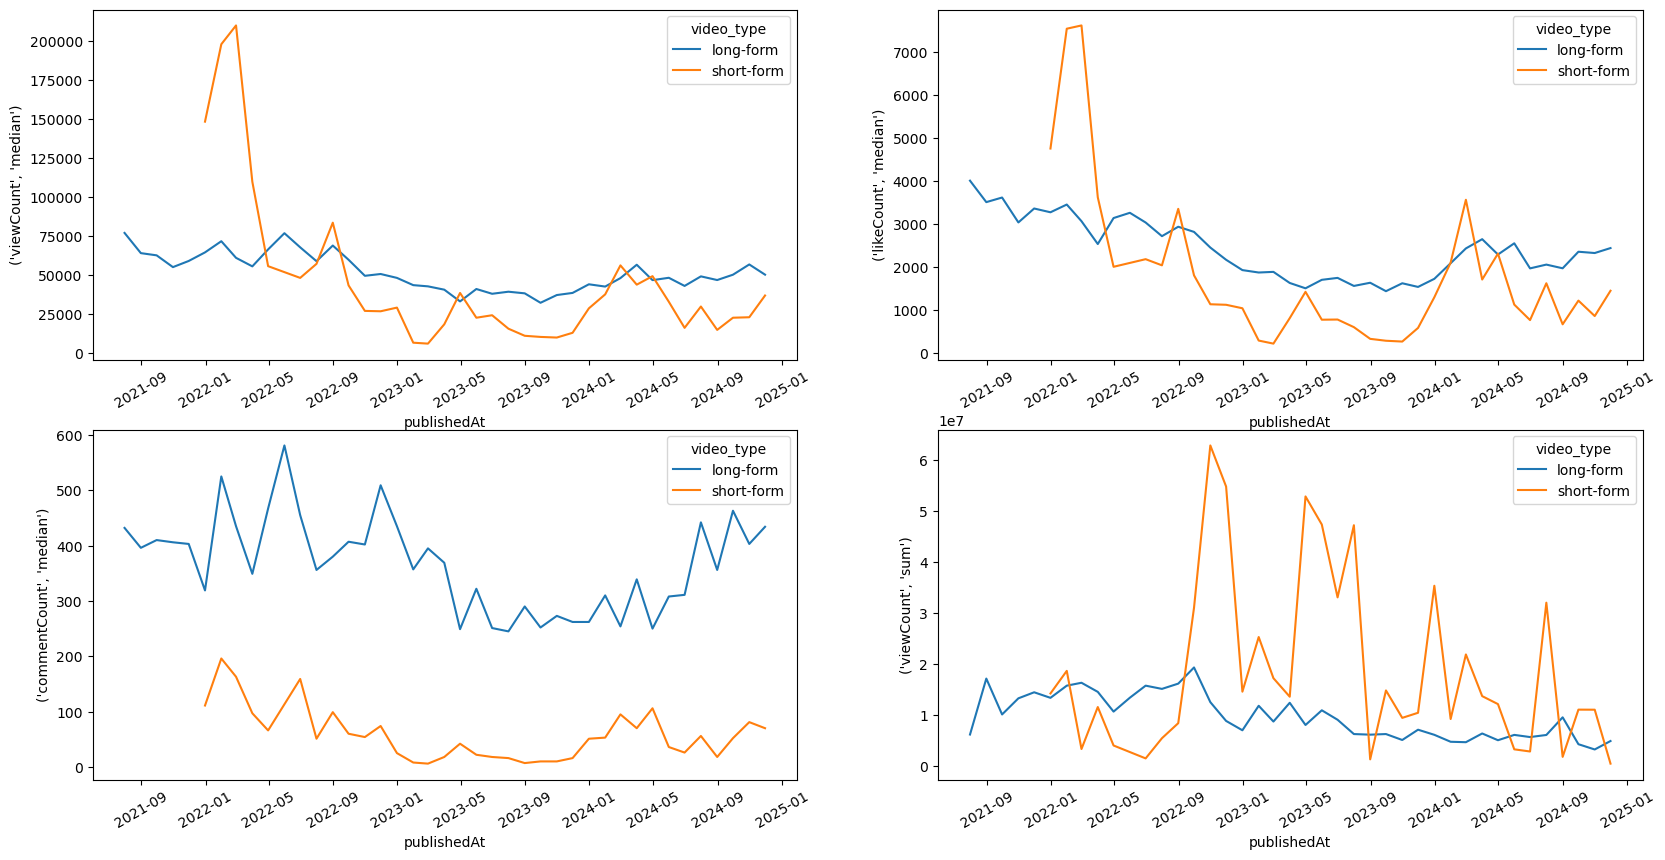

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

sns.lineplot(x=monthly_video_stats_all_filtered["publishedAt"], y=monthly_video_stats_all_filtered[("viewCount", "median")], hue=monthly_video_stats_all_filtered["video_type"], ax=axs[0, 0])

sns.lineplot(x=monthly_video_stats_all_filtered["publishedAt"], y=monthly_video_stats_all_filtered[("likeCount", "median")], hue=monthly_video_stats_all_filtered["video_type"], ax=axs[0, 1])


sns.lineplot(x=monthly_video_stats_all_filtered["publishedAt"], y=monthly_video_stats_all_filtered[("commentCount", "median")], hue=monthly_video_stats_all_filtered["video_type"], ax=axs[1, 0])


sns.lineplot(x=monthly_video_stats_all_filtered["publishedAt"], y=monthly_video_stats_all_filtered[("viewCount", "sum")], hue=monthly_video_stats_all_filtered["video_type"], ax=axs[1, 1])

for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

# Reference: https://stackoverflow.com/questions/31186019/rotate-tick-labels-in-subplot


plt.show()

In [ ]:
all_videos['shortForm'] = all_videos['video_type'].apply(lambda x: 1 if x == 'short-form' else 0)
all_videos["subscribers"] = all_videos["channelTitle"].map(channel_df.set_index("channelName")["subscribers"])

all_videos["viewCount_log"] = np.log(all_videos["viewCount"])
all_videos["subscribers_log"] = np.log(all_videos["subscribers"])

all_videos['subscribers_log_shortform'] = all_videos['subscribers_log'] * all_videos['shortForm']

In [875]:
y = all_videos['viewCount_log']
x = all_videos[['likeRatio', "commentCount", "subscribers_log", "shortForm","subscribers_log_shortform"]]

model = sm.OLS(y, x).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          viewCount_log   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          8.620e+04
Date:                Wed, 04 Dec 2024   Prob (F-statistic):                        0.00
Time:                        10:25:02   Log-Likelihood:                         -5346.5
No. Observations:                3737   AIC:                                  1.070e+04
Df Residuals:                    3732   BIC:                                  1.073e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

The variables that are statistically significant are the like ratio, the number of comments, and the number of subscribers.The interaction term between the number of subscribers and the short-form video type is also signficant, implying that subscriber count has a large impact on the views short form content gets.

# 5. Conclusion and Possible Future work

With the data extracted with the Youtube API, we were able to see how the personal finance space has been evolving, the trends and relationships regarding, views, use of keywords and emotionally charged language. We also analysed the impact YT shorts has had on channels. 

Future work using this data could benefit from using additional real world finacial data to analyse if videos have more emotional charged titles during times of financial downturn, seeing since people are more likely to look for help online on how to manage their finances or about financial news